In [112]:
#setup
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from IPython.display import display
from unidecode import unidecode
from gensim.corpora import Dictionary

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
# pd.options.mode.chained_assignment = None #disable a specific warning

# Creating the csv

In [113]:
from main import nlp_pipeline_result

# data = nlp_pipeline_result(
#     parser_parameters={
#         "remove_hashtag_word": True,
#         "replace_politics": True,
#         "replace_parties": True,
#     },
#     nlp_parameters={
#         "disable_parser": True,
#         "disable_ner": True
#     }
# )
# data['n_lemmas'] = data['Lemmas'].str.split().str.len()
# 
# data.to_csv('data/data.csv', index = False)

# Spliting train and test

In [114]:
data = pd.read_csv('data/data.csv')

train = data.sample(frac=0.8, random_state=420)
test = data.drop(train.index)
data = train

print(f"Len data: {len(data)}")
print(f"Len train: {len(train)}")
print(f"Len test: {len(test)}")

Len data: 11850
Len train: 11850
Len test: 2962


# Parsing Lemmas

In [115]:
def remove_accents(sentence):
    parsed_sentence = []
    for word in sentence.split(" "):
        if "ñ" in word:
            parsed_sentence.append(word)
        else:
            parsed_sentence.append(unidecode(word))
    return " ".join(parsed_sentence)

In [116]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_accents(str(x).lower()))

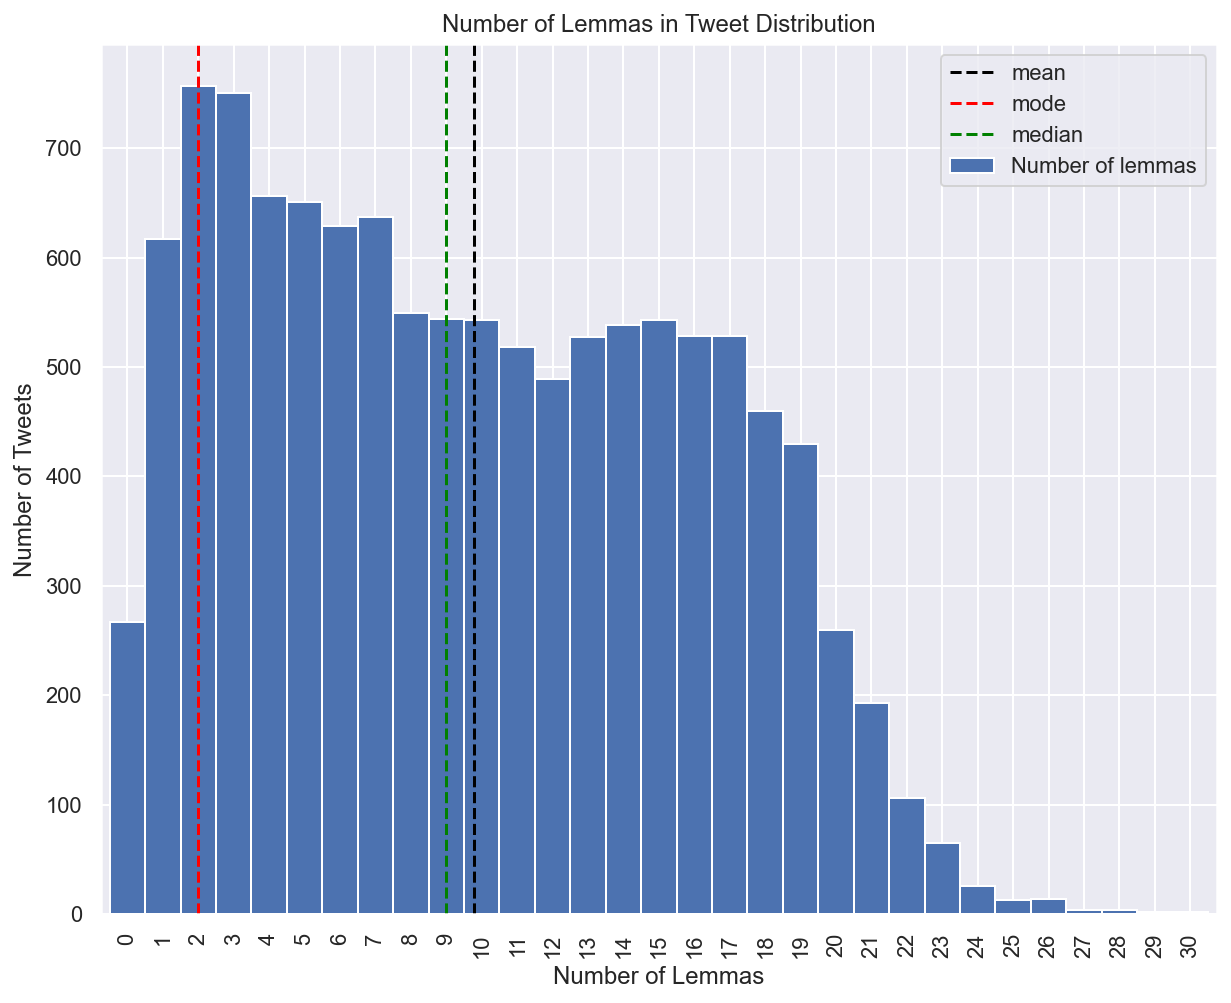

In [117]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar", width=1, label='Number of lemmas')
plt.axvline(x=data['n_lemmas'].mean(),
            label='mean', color='black',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].mode()[0],
            label='mode', color='red',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].median(),
            label='median', color='green',
            linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

In [118]:
data = data[data['n_lemmas'] >= 3]
print(f'Number of Tweets in Dataframe after removing short tweets: {len(data)}')

Number of Tweets in Dataframe after removing short tweets: 10209


# Creating the Corpus and Dictionary of terms

In [119]:
def from_df_to_token_dictionary (df, n_lemmas_threshold=3):
    
    df = df[df['n_lemmas'] >= n_lemmas_threshold]
    print(f'Number of Tweets in Dataframe after removing short tweets: {len(df)}')
    
    tweets_corpus = [el.split() for el in df["Lemmas"]]
    # display(tweets_corpus)
    
    token_dic = Dictionary(tweets_corpus)
    return token_dic, tweets_corpus

In [120]:
token_dic, tweet_corpus = from_df_to_token_dictionary(data, n_lemmas_threshold=3)

Number of Tweets in Dataframe after removing short tweets: 10209


In [121]:
def create_word_freq(token_dic):
    word_freq = {}
    for k, v in token_dic.items():
        word_freq[v] = token_dic.cfs[k]

    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_word_freq

In [122]:
sorted_word_freq = create_word_freq(token_dic)
# print(sorted_word_freq)

# Plot and analysis of term Dictionary stuff

In [123]:
def plot_frequencies(collection):
    collfreq = sorted(collection.items()) 
    x, y = zip(*collfreq) 
    plt.plot(x, y)

In [124]:
def compute_token_mean_max(collection):
    count, _sum = 0, 0
    for key in collection:
        count += 1
        _sum += collection[key]
    
    instances_max = max(collection.values())
    instances_mean = _sum/count
    
    return instances_max, instances_mean

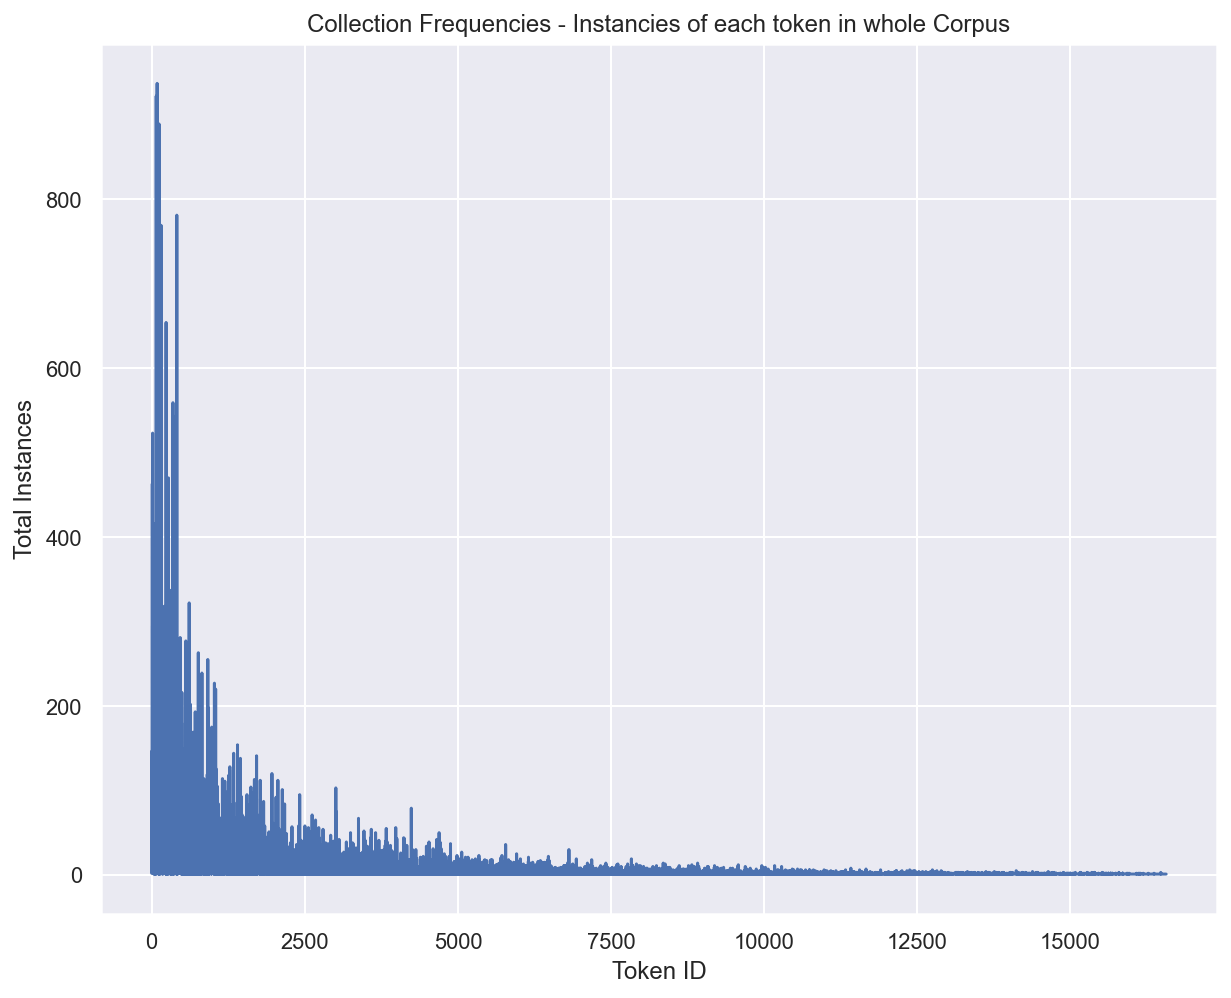

Max of occurances per topic: 937
Mean of occurances per topic: 6.8694680915293125


In [125]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.
plot_frequencies(token_dic.cfs)
plt.title('Collection Frequencies - Instancies of each token in whole Corpus')
plt.xlabel('Token ID')
plt.ylabel('Total Instances')
plt.show()

instances_max, instances_mean = compute_token_mean_max(token_dic.cfs)

print(f"Max of occurances per topic: {instances_max}")
print(f"Mean of occurances per topic: {instances_mean}")

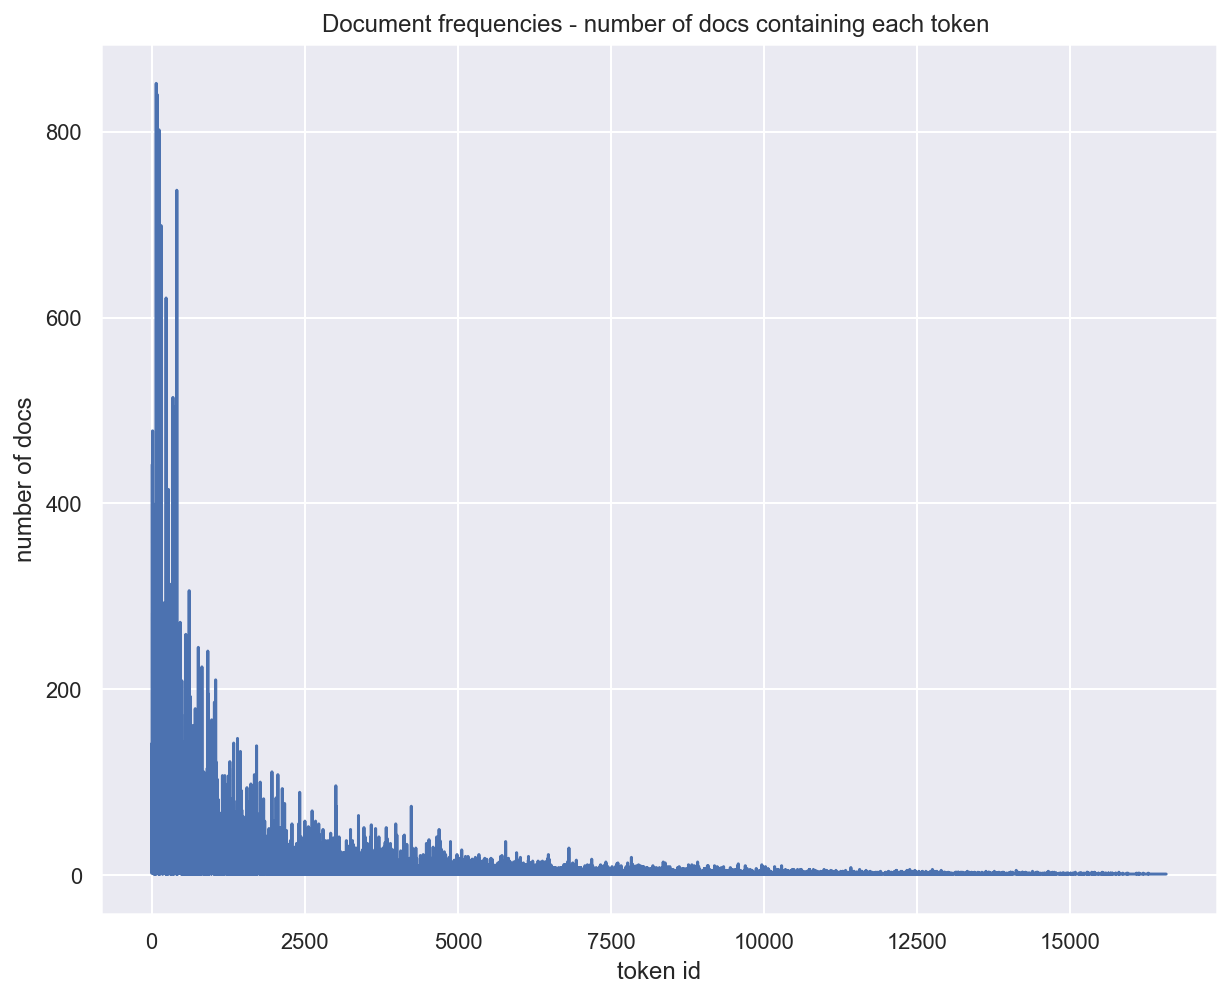

Max of docs in which a token appears: 852
Mean of docs in which token appears: 6.622532149972831


In [126]:
# Document frequencies: token_id -> how many documents contain this token
plot_frequencies(token_dic.dfs)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('token id')
plt.ylabel('number of docs')
plt.show()

docs_max, docs_mean = compute_token_mean_max(token_dic.dfs)

print(f"Max of docs in which a token appears: {docs_max}")
print(f"Mean of docs in which token appears: {docs_mean}")

# Choosing hyperparameters for filtering extremes

In [105]:
#FILTER TOKEN DICTIONARY

no_below_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #Minimum number of documents to keep a term in the dictionary
no_above_list = [.5, .4, .3, .2, .05, .04, .03, .02, .005, .004, .003, .002, .0005, .0004, 0.0003, .0002] #Maximum proportion of documents in which a term can appear to be kept in the dictionary

filtered_dict = copy.copy(token_dic)  # copy of the token dictionary for latter filtering lemmas
prev_tokens = len(token_dic)

# print('The dictionary contained', prev_tokens, 'terms')

# for i in no_below_list:
    
#     for j in no_above_list:
        
#         token_dic = Dictionary(tweets_corpus)
        
#         token_dic.filter_extremes(no_below=i,no_above=j)
        
#         n_tokens = len(token_dic)
        
#         print(n_tokens, 'terms |no_below = ', i, "| no_above = ", j)



#print('First terms in the dictionary:')
#for n in range(500):
#    print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY

In [106]:
filtered_dict.filter_extremes(no_below=3, no_above=1)

print(f'The dictionary contains {len(filtered_dict)} terms')

The dictionary contains 5151 terms


# Obtaining BOW from filtered Dictionary

In [107]:
# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)

tweets_corpus_bow = [filtered_dict.doc2bow(doc) for doc in tweets_corpus]

# Applying LDA and Ploting it for visualization of terms in topics

In [108]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

num_topics = 15

ldamallet = LdaMallet(
    mallet_path,
    corpus=tweets_corpus_bow,
    num_topics=num_topics,
    id2word=filtered_dict,
    alpha=5,
    iterations=100
)

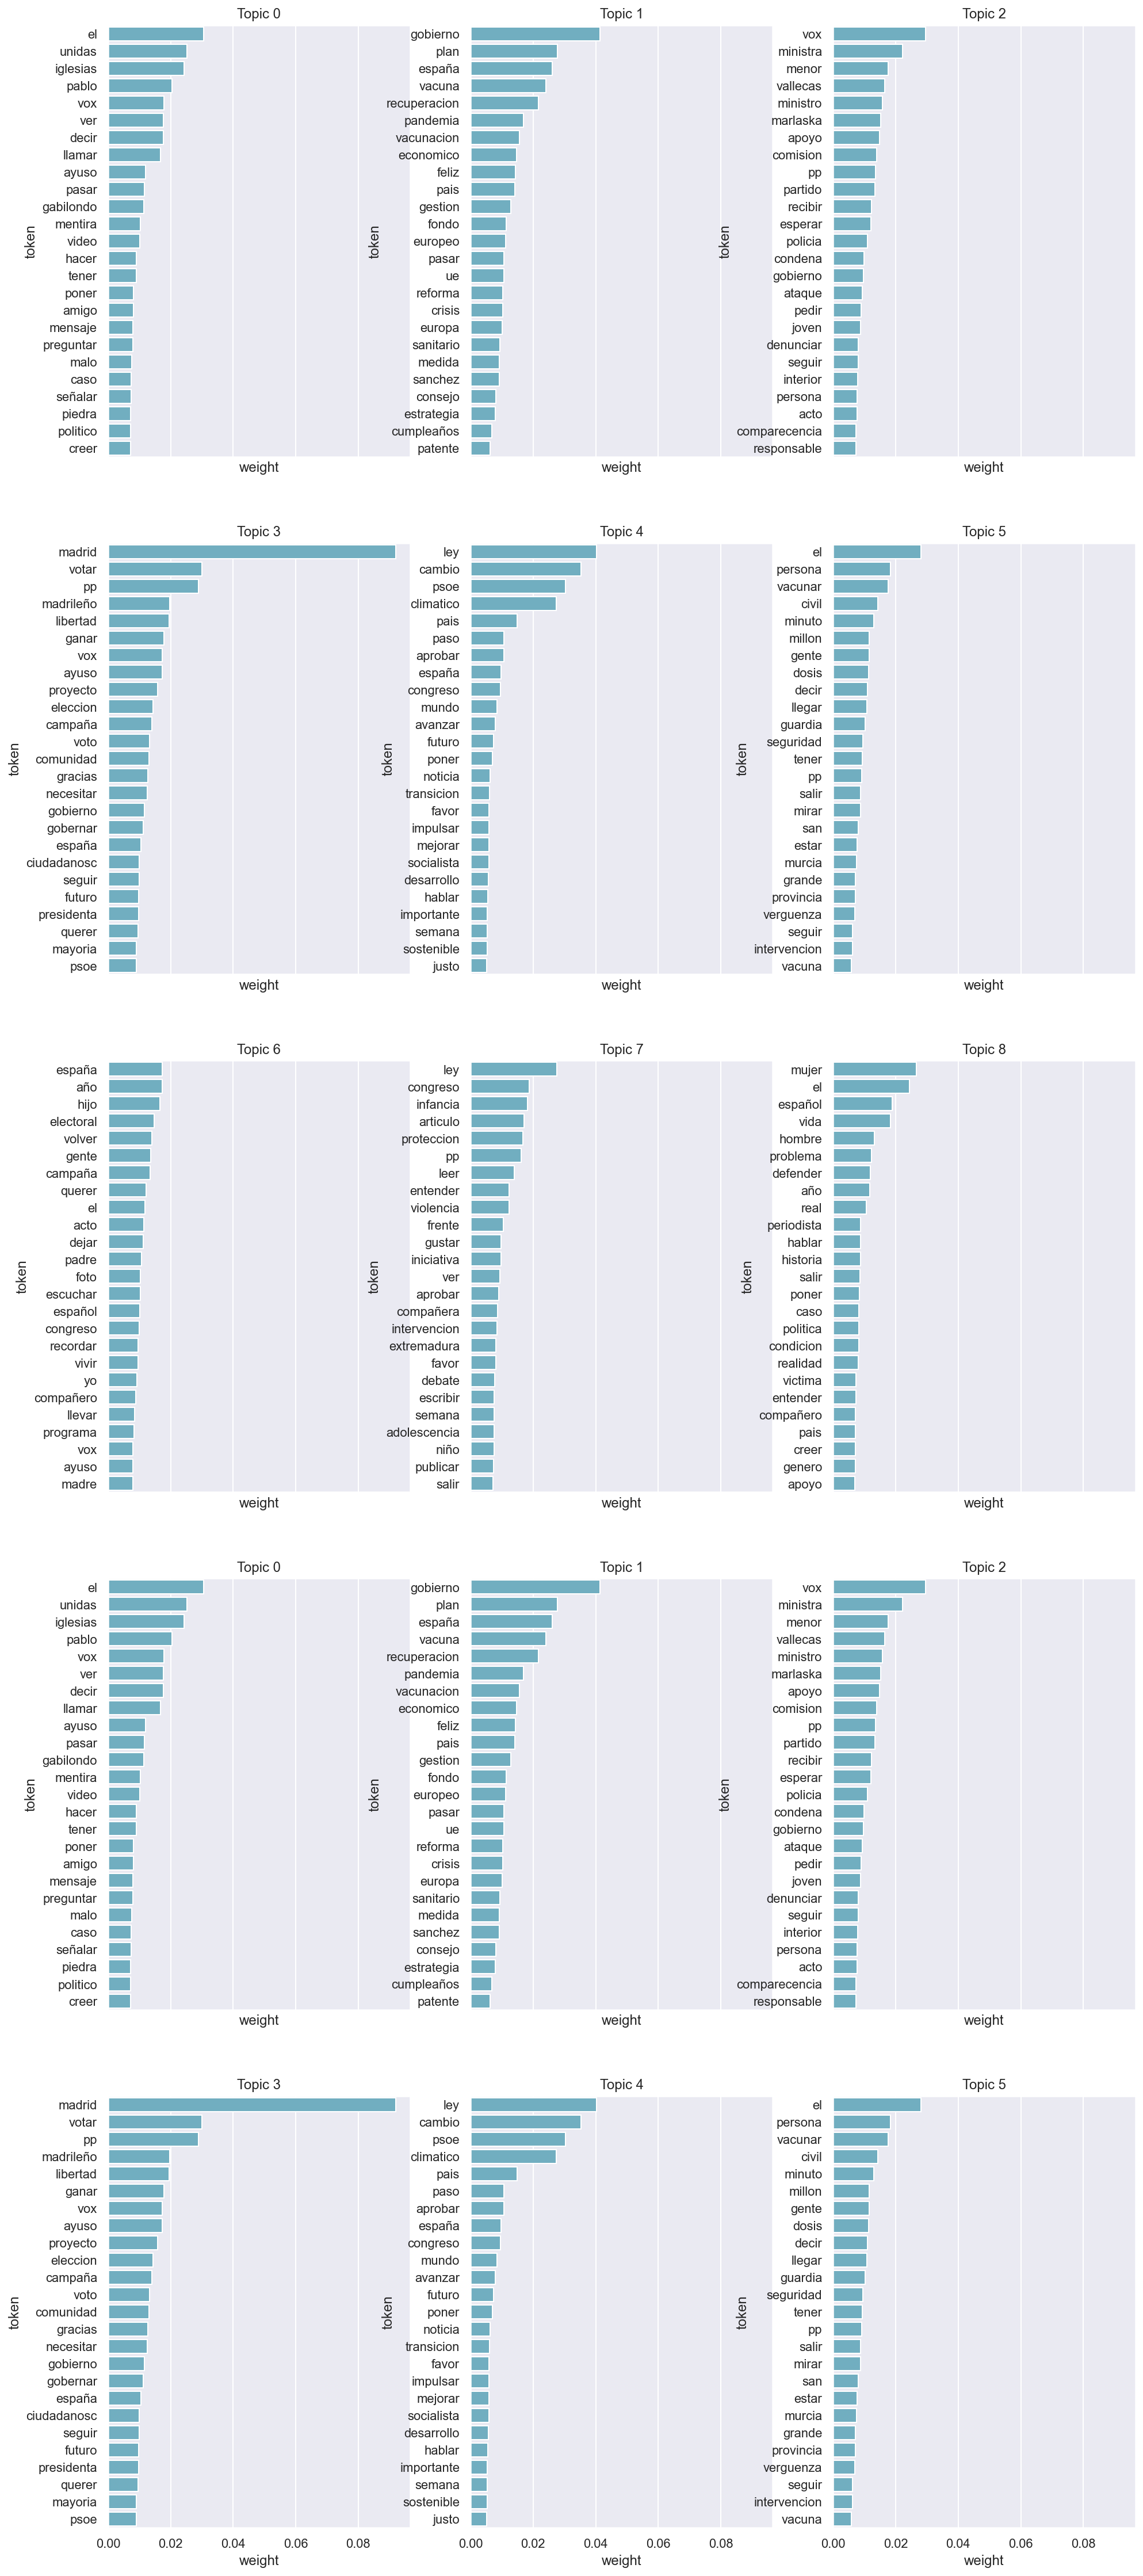

In [111]:
topn = 25

rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 40), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%cols), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%cols)}')

plt.show()

# Specific stopword removal

In [ ]:
specific_stw = [
    'el', 'año', 'vivir', 'hacer', 'plan',
    'sector', 'salir', 'gestion', 'resto',
    'ir', 'yo', 'ley', 'gobierno', 'serio',
    'nacional', 'acto', 'minuto', 'explicar',
    'estar', 'poner', 'discurso', 'pedir',
    'volver', 'alto', 'punto', 'pasar', 'pais',
    'dar', 'quedar', 'hablar', 'decir', 'dejar',
    'ver', 'paso', 'importante', 'aprobar', 'gente'
]

specific_stw = [
    'dato', 'llegar', 'politica', 'venir', 'leer',
    'seguir', 'entender', 'tener', 'llevar', 'convertir',
    'directo', 'partido', 'cara', 'caso', 'hilo', 'gracia',
    'favor', 'medio', 'forma', 'senor', 'empezar'
]

specific_stw = list(set([el.lower() for el in specific_stw]))

In [ ]:
def remove_stpwrd(string, specific_stw_eliminate):
    splitted = string.split()
    resultwords  = [word for word in splitted if word.lower() not in specific_stw_eliminate]
    result = ' '.join(resultwords)
    return result

In [ ]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_stpwrd(str(x), specific_stw))

data['n_lemmas'] =  data['Lemmas'].str.split().str.len()
#print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(NSF_df))

# Again, create corpus, dictionary and filter the dictionary

In [ ]:
token_dic, tweet_corpus = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_token_dic.filter_extremes(no_below=3, no_above=1)
tweets_corpus_bow = [filtered_token_dic.doc2bow(doc) for doc in tweets_corpus]

# Choosing hyperparameter number of topics

In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

list(range(60,3,-10))

In [ ]:
tc = []
n_topics = range(150,3,-15)

for i, ntpc in enumerate(n_topics):
    lda_ntcp = LdaModel(
        corpus=tweets_corpus_bow, 
        id2word=token_dic, 
        num_topics=ntpc
    )
    tc.append(
        CoherenceModel(
            lda_ntcp,
            texts=tweets_corpus,
            dictionary=token_dic,
            coherence='c_v').get_coherence()
    )
    print(f'Tested {i+1} models out of {len(n_topics)}')

In [ ]:
plt.figure()
plt.plot(n_topics, tc)
plt.xticks(n_topics,n_topics)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

In [ ]:
#fine tune
n_topics = range(3,20,4)
tc = []

for i, ntpc in enumerate(n_topics):
    lda_ntcp = LdaModel(
        corpus=tweets_corpus_bow, 
        id2word=token_dic, 
        num_topics=ntpc
    )
    tc.append(
        CoherenceModel(
            lda_ntcp,
            texts=tweets_corpus,
            dictionary=token_dic,
            coherence='c_v').get_coherence()
    )
    print(f'Tested {i+1} models out of {len(n_topics)}')

plt.figure()
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

In [ ]:
# print(list(ldamallet.load_document_topics()))
# print(len(list(ldamallet.load_document_topics())))

"""
rec = []
for topic in ldamallet.load_document_topics():
    rec.append([value[1] for value in topic])
       
df = pd.DataFrame(rec)

print(len(df), len(data))


df['Likes'] = data.sort_index()["Likes"].to_list()
df['Retweets'] = data.sort_index()["Retweets"].to_list()
df["Party"] = data.sort_index()["Party"].to_list()
df
"""